In [1]:
import time
import gc

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

# データロード

In [2]:
df_train = pd.read_pickle('input/train.pkl')
df_test = pd.read_pickle('input/test.pkl')
df_test_s = pd.read_pickle('input/test_supplement.pkl')

In [3]:
print(df_train.shape)
print(df_train.head())

print(df_test.shape)
print(df_test.head())

print(df_test_s.shape)
print(df_test.head())

(184903890, 8)
       ip  app  device  os  channel          click_time attributed_time  \
0   83230    3       1  13      379 2017-11-06 14:32:21             NaN   
1   17357    3       1  19      379 2017-11-06 14:33:34             NaN   
2   35810    3       1  13      379 2017-11-06 14:34:12             NaN   
3   45745   14       1  13      478 2017-11-06 14:34:52             NaN   
4  161007    3       1  13      379 2017-11-06 14:35:08             NaN   

   is_attributed  
0              0  
1              0  
2              0  
3              0  
4              0  
(18790469, 7)
   click_id      ip  app  device  os  channel          click_time
0         0    5744    9       1   3      107 2017-11-10 04:00:00
1         1  119901    9       1   3      466 2017-11-10 04:00:00
2         2   72287   21       1  19      128 2017-11-10 04:00:00
3         3   78477   15       1  13      111 2017-11-10 04:00:00
4         4  123080   12       1  13      328 2017-11-10 04:00:00
(57537505,

# EDA

## TrainとTestの差、click_timeに着目して

2017-11-09 16:00:00
2017-11-06 14:32:21
184903890


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


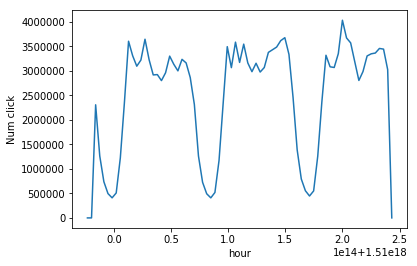

In [4]:
print(df_train["click_time"].max())
print(df_train["click_time"].min())
print(df_train["click_time"].shape[0])

counts_train = df_train["click_time"].groupby([df_train["click_time"].dt.year,
                        df_train["click_time"].dt.month,
                        df_train["click_time"].dt.day,
                        df_train["click_time"].dt.hour]).agg({'click_time': 'count'})

num_click_train = counts_train.values.reshape(1,-1)[0]
hours_train = pd.date_range("2017-11-06-14", df_train["click_time"].max(), freq="H").to_datetime()

plt.plot(hours_train,num_click_train)
plt.ylabel('Num click')
plt.xlabel('hour')
plt.show()

2017-11-10 15:00:00
2017-11-10 04:00:00
18790469


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


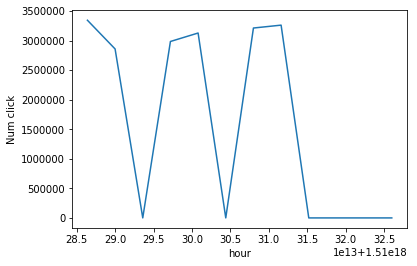

In [5]:
print(df_test["click_time"].max())
print(df_test["click_time"].min())
print(df_test["click_time"].shape[0])

counts_test = df_test["click_time"].groupby([df_test["click_time"].dt.year,
                        df_test["click_time"].dt.month,
                        df_test["click_time"].dt.day,
                        df_test["click_time"].dt.hour]).agg({'click_time': 'count'})

counts_test.loc[((2017, 11, 10, 7))] = 0
counts_test.loc[((2017, 11, 10, 8))] = 0
counts_test.loc[((2017, 11, 10, 12))] = 0
counts_test.loc[((2017, 11, 10, 15))] = 0


num_click_test = counts_test.values.reshape(1,-1)[0]
hours_test = pd.date_range(df_test["click_time"].min(), df_test["click_time"].max(), freq="H").to_datetime()

plt.plot(hours_test,num_click_test)
plt.ylabel('Num click')
plt.xlabel('hour')
plt.show()

## Target(is_attributed)に着目して
trainデータの中の"is_attributed"
- 0: 184447044→全体の0.99752927858900098
- 1: 456846→全体の0.0024707214109989791

Testデータで不自然にサンプル数少ない、6,7,8,12,15時を除いた場合
- 0: 138103894
- 1: 340878→全体の0.0024621948165727773

さらに、前日9日のみ
- 0: 36987418
- 1:    93786→全体の0.0025292059017285413

*9日だけ使ってもいいんちゃうの？*

In [8]:
tr_att = df_train["is_attributed"]
tr_att.value_counts()
print(tr_att.value_counts()[1] / tr_att.shape[0])

0.002470721411


In [9]:
tr_att_wo6781115 = df_train[(df_train['click_time'].dt.hour != 6) &
                              (df_train['click_time'].dt.hour != 7) &
                              (df_train['click_time'].dt.hour != 8) &
                              (df_train['click_time'].dt.hour != 11)&
                              (df_train['click_time'].dt.hour != 15)]['is_attributed']

print(tr_att_wo6781115.value_counts())
print(tr_att_wo6781115.value_counts()[1] / tr_att_wo6781115.shape[0])

0    138103894
1       340878
Name: is_attributed, dtype: int64
0.00246219481657


In [10]:
tr_att_wo6781115_9th =  df_train[(df_train['click_time'].dt.day == 9)  &
                                   (df_train['click_time'].dt.hour != 6) &
                                   (df_train['click_time'].dt.hour != 7) &
                                   (df_train['click_time'].dt.hour != 8) &
                                   (df_train['click_time'].dt.hour != 11)&
                                   (df_train['click_time'].dt.hour != 15)]['is_attributed']

print(tr_att_wo6781115_9th.value_counts())
print(tr_att_wo6781115_9th.value_counts()[1] / tr_att_wo6781115_9th.shape[0])

0    36987418
1       93786
Name: is_attributed, dtype: int64
0.00252920590173


In [11]:
del tr_att, tr_att_wo6781115, tr_att_wo6781115_9th
gc.collect()

5312

## Train(allとlimit)とTestの差をヒストグラムで

In [12]:
ips_tr =  df_train["ip"]
ips_tst = df_test["ip"]

In [13]:
ips_tr.nunique()

277396

In [14]:
ips_tst.nunique()

93936

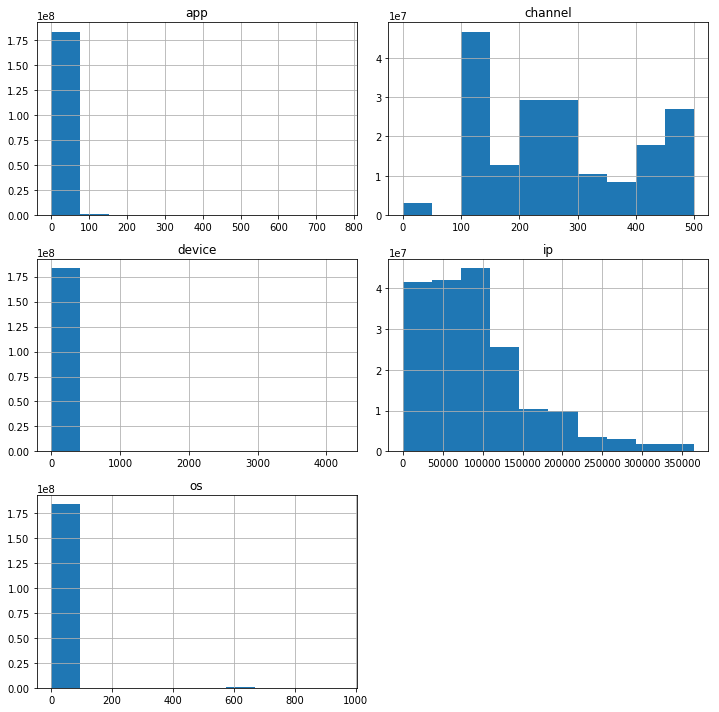

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

df_tr_all = df_train[["ip", "app", "device", "os", "channel"]]
df_tr_all.hist()
plt.tight_layout()

In [ ]:
df_tr_limit = df_train[(df_train['click_time'].dt.day == 9)  &
                        (df_train['click_time'].dt.hour != 6) &
                        (df_train['click_time'].dt.hour != 7) &
                        (df_train['click_time'].dt.hour != 8) &
                        (df_train['click_time'].dt.hour != 11)&
                        (df_train['click_time'].dt.hour != 15)] \
                        [["ip", "app", "device", "os", "channel"]]
df_tr_limit.hist()
plt.tight_layout()

In [ ]:
df_test = df_test[["ip", "app", "device", "os", "channel"]]
df_test.hist()
plt.tight_layout()

In [ ]:
df_tr_limit["ip"].hist(color="#5F9BFF", alpha=.5)
df_test["ip"].hist(color="#F8766D", alpha=.5)
plt.show()